In [1]:
from sdo.sood.data.sdo_ml_v2_dataset import SDOMLv2DataModule, SDOMLv2NumpyDataset

In [2]:
from pathlib import Path
import numpy as np
import os 
import sunpy
from sunpy.visualization.colormaps import cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torchvision
import torch
import torchvision.transforms.functional as F

#inspect an image

#Channels that correspond to HMI Magnetograms 
HMI_WL = ['Bx','By','Bz']
#A colormap for visualizing HMI
HMI_CM = LinearSegmentedColormap.from_list("bwrblack", ["#0000ff","#000000","#ff0000"])

def channel_to_map(name):
    """Given channel name, return colormap"""
    return HMI_CM if name in HMI_WL else cm.cmlist.get('sdoaia%d' % int(name))

def get_clip(X,name):
    """Given an image and the channel name, get the right clip"""
    return get_signed_pct_clip(X) if name in HMI_WL else get_pct_clip(X)

def get_pct_clip(X):
    """Return the 99.99th percentile"""
    return (0,np.quantile(X.ravel(),0.999))

def get_signed_pct_clip(X):
    """Return the 99.99th percentile by magnitude, but symmetrize it so 0 is in the middle"""
    v = np.quantile(np.abs(X.ravel()),0.999)
    return (-v,v)

def vis(X, cm, clip):
    """Given image, colormap, and a clipping, visualize results"""
    Xc = np.clip((X-clip[0])/(clip[1]-clip[0]),0,1)
    Xcv = cm(Xc)
    return (Xcv[:,:,:3]*255).astype(np.uint8)

def show_grid(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(figsize=(24,24), ncols=4, nrows=int(len(imgs)/4), squeeze=False)
    row = 0
    for i, img in enumerate(imgs):
        col = i % 4
        if i != 0 and i % 4 == 0:
            row = row + 1
        axs[row, col].imshow(img)
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [3]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_small.zarr/", channel="193A", train_start="2010-08-27 00:00:00", train_end="2010-08-28 23:59:59", test_start="2010-08-29 00:00:00", test_end="2010-08-29 23:59:59", train_val_split_temporal_chunk_size="1h", prefetch_factor=2, irradiance=1e-6, goes_cache_dir="../tmp/new").train_dataloader()


discovered the following zarr directory structure
/
 └── 2010
     ├── 131A (6135, 512, 512) float32
     ├── 1600A (6136, 512, 512) float32
     ├── 1700A (6135, 512, 512) float32
     ├── 171A (6135, 512, 512) float32
     ├── 193A (6135, 512, 512) float32
     ├── 211A (6136, 512, 512) float32
     ├── 304A (6134, 512, 512) float32
     ├── 335A (6135, 512, 512) float32
     └── 94A (6136, 512, 512) float32
filtering data between 2010-08-27 00:00:00 and 2010-08-28 23:59:59


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None


found 477 images


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F.zgroup?alt=media, (), {}
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None


discovered the following zarr directory structure


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F2010%2F.zgroup?alt=media, (), {}
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('f

/
 └── 2010
     ├── 131A (6135, 512, 512) float32
     ├── 1600A (6136, 512, 512) float32
     ├── 1700A (6135, 512, 512) float32
     ├── 171A (6135, 512, 512) float32
     ├── 193A (6135, 512, 512) float32
     ├── 211A (6136, 512, 512) float32
     ├── 304A (6134, 512, 512) float32
     ├── 335A (6135, 512, 512) float32
     └── 94A (6136, 512, 512) float32
filtering data between 2010-08-29 00:00:00 and 2010-08-29 23:59:59
found 239 images
Selecting groups for train-validation split. Number of groups 48, number of groups for training 34, number of groups for validation 14
splitting Dataset into two subsets. Train size 337, validation size 140


DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F2010%2F193A%2F152.0.0?alt=media, (), {}
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F2010%2F193A%2F153.0.0?alt=media, (), {}
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F2010%2F193A%2F154.0.0?alt=media, (), {}
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F2010%2F193A%2F155.0.0?alt=media, (), {}
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F2010%2F193A%2F156.0.0?alt=media, (), {}
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F2010%2F193A%2F157.0.0?alt=media, (), {}
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_small.zarr%2F2010%2F193A%2F158.

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/mariusgiger/repos/master/sdo-cli/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/mariusgiger/repos/master/sdo-cli/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/mariusgiger/repos/master/sdo-cli/.venv/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/mariusgiger/repo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Avenir Next Condensed.ttc', name='Avenir Next Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMongolian-Regular.ttf', name='Noto Sans Mongolian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBamum-Regular.ttf', name='Noto Sans Bamum', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpSmReg.otf', name='STIXIntegralsUpSm', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldItalic-Regular.ttf', name='Noto Sans Old Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Zapfino.ttf', name='Zapfino', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCypriot-Regular.ttf', name='Noto Sans Cypriot', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTaiTham-Regular.ttf', name='Noto Sans Tai Tham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: scor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72.ttc', name='Bodoni 72', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuhid-Regular.ttf', name='Noto Sans Buhid', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Wingdings 3.ttf', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille Outline 6 Dot.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Bold Italic.ttf', name='Arial Narrow', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSDisplayCondensed-Regular.otf', name='.SF NS Display Condensed', style='normal', variant='normal', weight=600, stretch='condensed', size='scalable')) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/LucidaGrande.ttc', name='Lucida Grande', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 2.872272727272727
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBatak-Regular.ttf', name='Noto Sans Batak', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: sc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKaithi-Regular.ttf', name='Noto Sans Kaithi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Bold.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 6.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansChakma-Regular.ttf', name='Noto Sans Chakma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCuneiform-Regular.ttf', name='Noto Sans Cuneiform', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfon

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizThreeSymReg.otf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kannada MN.ttc', name='Kannada MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralBolIta.otf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSerifCaption.ttc', name='PT Serif Caption', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/STHeiti Medium.ttc', name='Heiti TC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Devanagari Sangam MN.ttc', name='Devanagari Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/ChalkboardSE.ttc', name='Chalkboard SE', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Telugu MN.ttc', name='Telugu MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplem

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansPhoenician-Regular.ttf', name='Noto Sans Phoenician', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansShavian-Regular.ttf', name='Noto Sans Shavian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Skia.ttf', name='Skia', style='normal', variant='normal', weight=5, stretch='normal', size='scalable')) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Georgia Bold.ttf', name='Georgia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Syste

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/SuperClarendon.ttc', name='Superclarendon', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Italic.ttf', name='Arial Narrow', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Krungthep.ttf', name='Krungthep', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Avenir.ttc', name='Avenir', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Courier

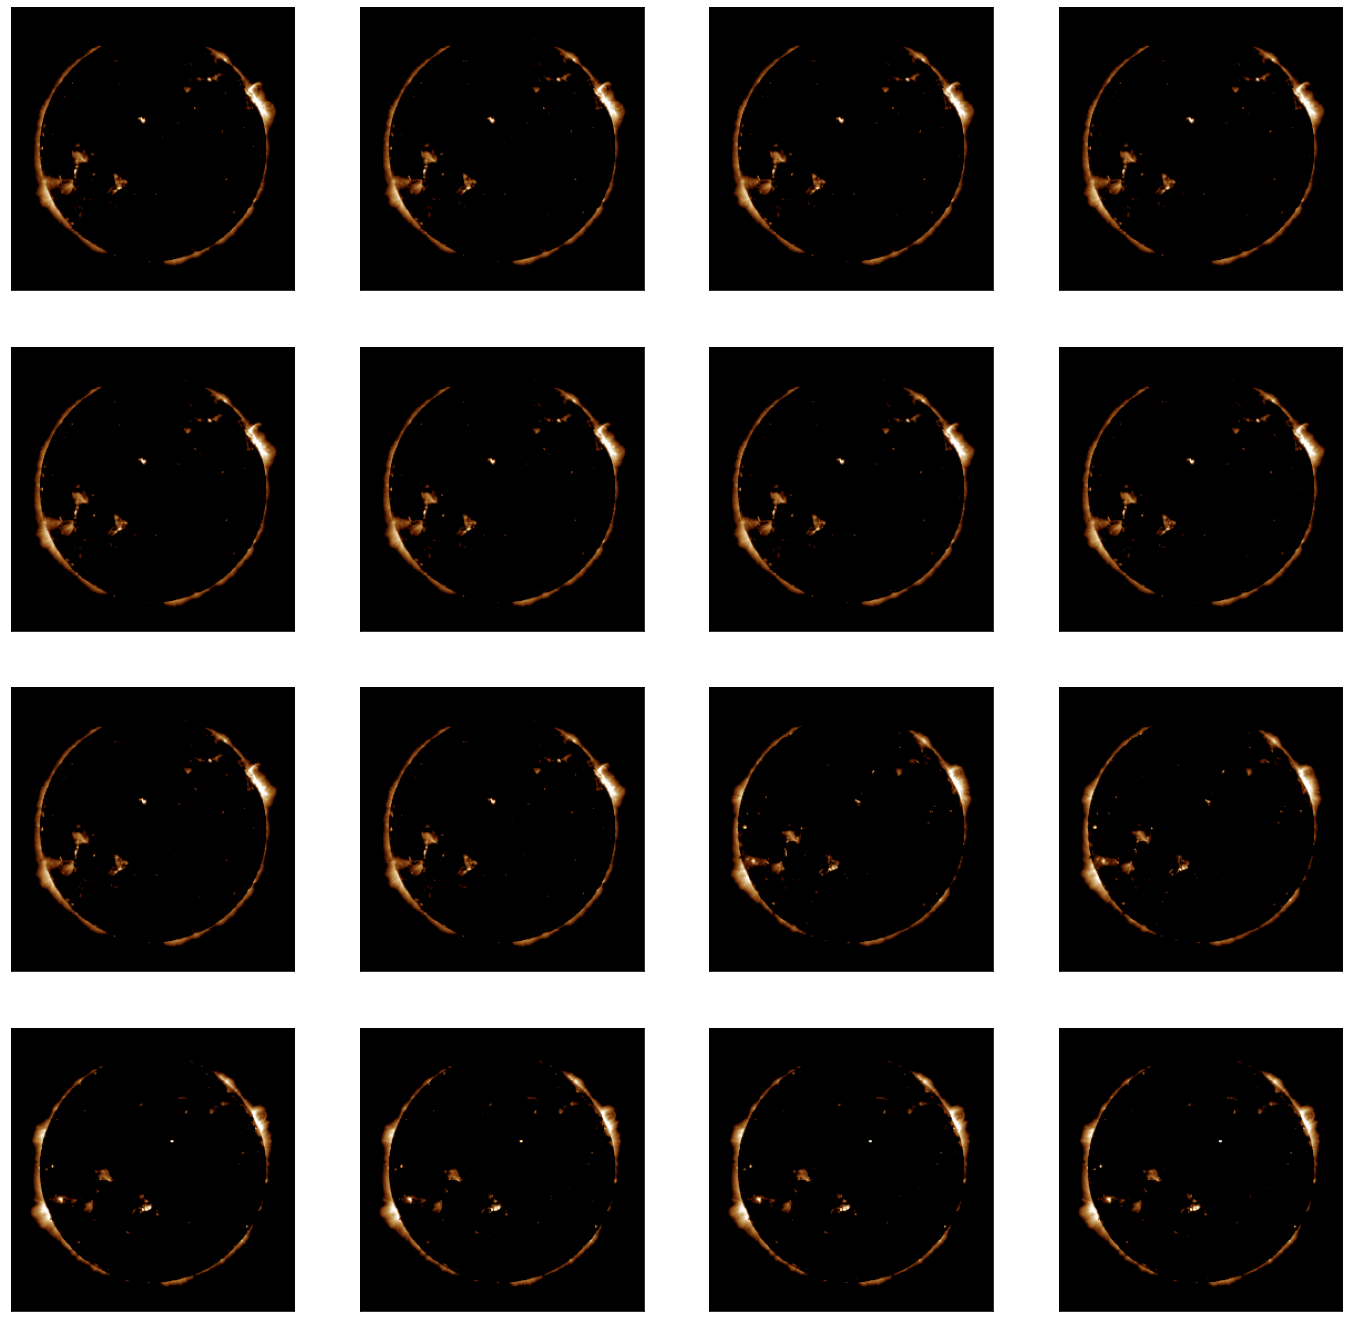

In [7]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map(193), get_clip(x, 171))
        V.append(Image.fromarray(v))
    show_grid(V)
    break

In [8]:
for key in y.keys():
    print("%s %s" % (key, y[key][0]))

ACS_CGT GT3
ACS_ECLP NO
ACS_MODE SCIENCE
ACS_SAFE NO
ACS_SUNP YES
AECDELAY tensor(1545)
AECMODE ON
AECTYPE tensor(0)
AGT1SVY tensor(0)
AGT1SVZ tensor(4)
AGT2SVY tensor(0)
AGT2SVZ tensor(-5)
AGT3SVY tensor(1)
AGT3SVZ tensor(0)
AGT4SVY tensor(1)
AGT4SVZ tensor(-3)
AIAECENF tensor(1)
AIAECTI tensor(0)
AIAGP1 tensor(0)
AIAGP10 tensor(748)
AIAGP2 tensor(0)
AIAGP3 tensor(0)
AIAGP4 tensor(0)
AIAGP5 tensor(0)
AIAGP6 tensor(0)
AIAGP7 tensor(0)
AIAGP8 tensor(280)
AIAGP9 tensor(344)
AIAHFSN tensor(11006886)
AIASEN tensor(6)
AIAWVLEN tensor(3)
AICFGDL1 tensor(0)
AICFGDL2 tensor(24)
AICFGDL3 tensor(88)
AICFGDL4 tensor(236)
AIFCPS tensor(55)
AIFDBID tensor(241)
AIFILTYP tensor(0)
AIFOENFL tensor(1)
AIFRMLID tensor(2908)
AIFTSID tensor(40962)
AIFTSWTH tensor(0)
AIFWEN tensor(270)
AIHIS192 tensor(0)
AIHIS348 tensor(0)
AIHIS604 tensor(0)
AIHIS860 tensor(0)
AIHISMXB tensor(0)
AIMGFSN tensor(2)
AIMGOTS tensor(1661623241)
AIMGOTSS tensor(46071)
AIMGSHCE tensor(2900)
AIMGSHEN tensor(4)
AIMGTYP tensor(0)
AI

In [10]:
loader = SDOMLv2DataModule("fdl-sdoml-v2/sdomlv2_hmi_small.zarr/", channel="Bx", batch_size=16, prefetch_factor=2).train_dataloader()

DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F.zgroup?

discovered the following zarr directory structure


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F2010%2F.zgroup?alt=media, (), {}
DEBUG:gcsfs:GET: b/{}/o,

/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32
found 25540 images


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F.zgroup?alt=media, (), {}
DEBUG:gcsfs:GET: b/{}/o, ('fdl-

discovered the following zarr directory structure


DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: b/{}/o, ('fdl-sdoml-v2',), None
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F2010%2F.zgroup?alt=media, (), {}
DEBUG:gcsfs:GET: b/{}/o,

/
 └── 2010
     ├── Bx (25540, 512, 512) float32
     ├── By (25540, 512, 512) float32
     └── Bz (25540, 512, 512) float32
found 25540 images
Selecting groups for train-validation split. Number of groups 18, number of groups for training 13, number of groups for validation 5
splitting Dataset into two subsets. Train size 18714, validation size 6826


DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F2010%2FBx%2F312.0.0?alt=media, (), {}
DEBUG:gcsfs:GET: https://storage.googleapis.com/download/storage/v1/b/fdl-sdoml-v2/o/sdomlv2_hmi_small.zarr%2F2010%2FBx%2F311.0.0?alt=media, (), {}


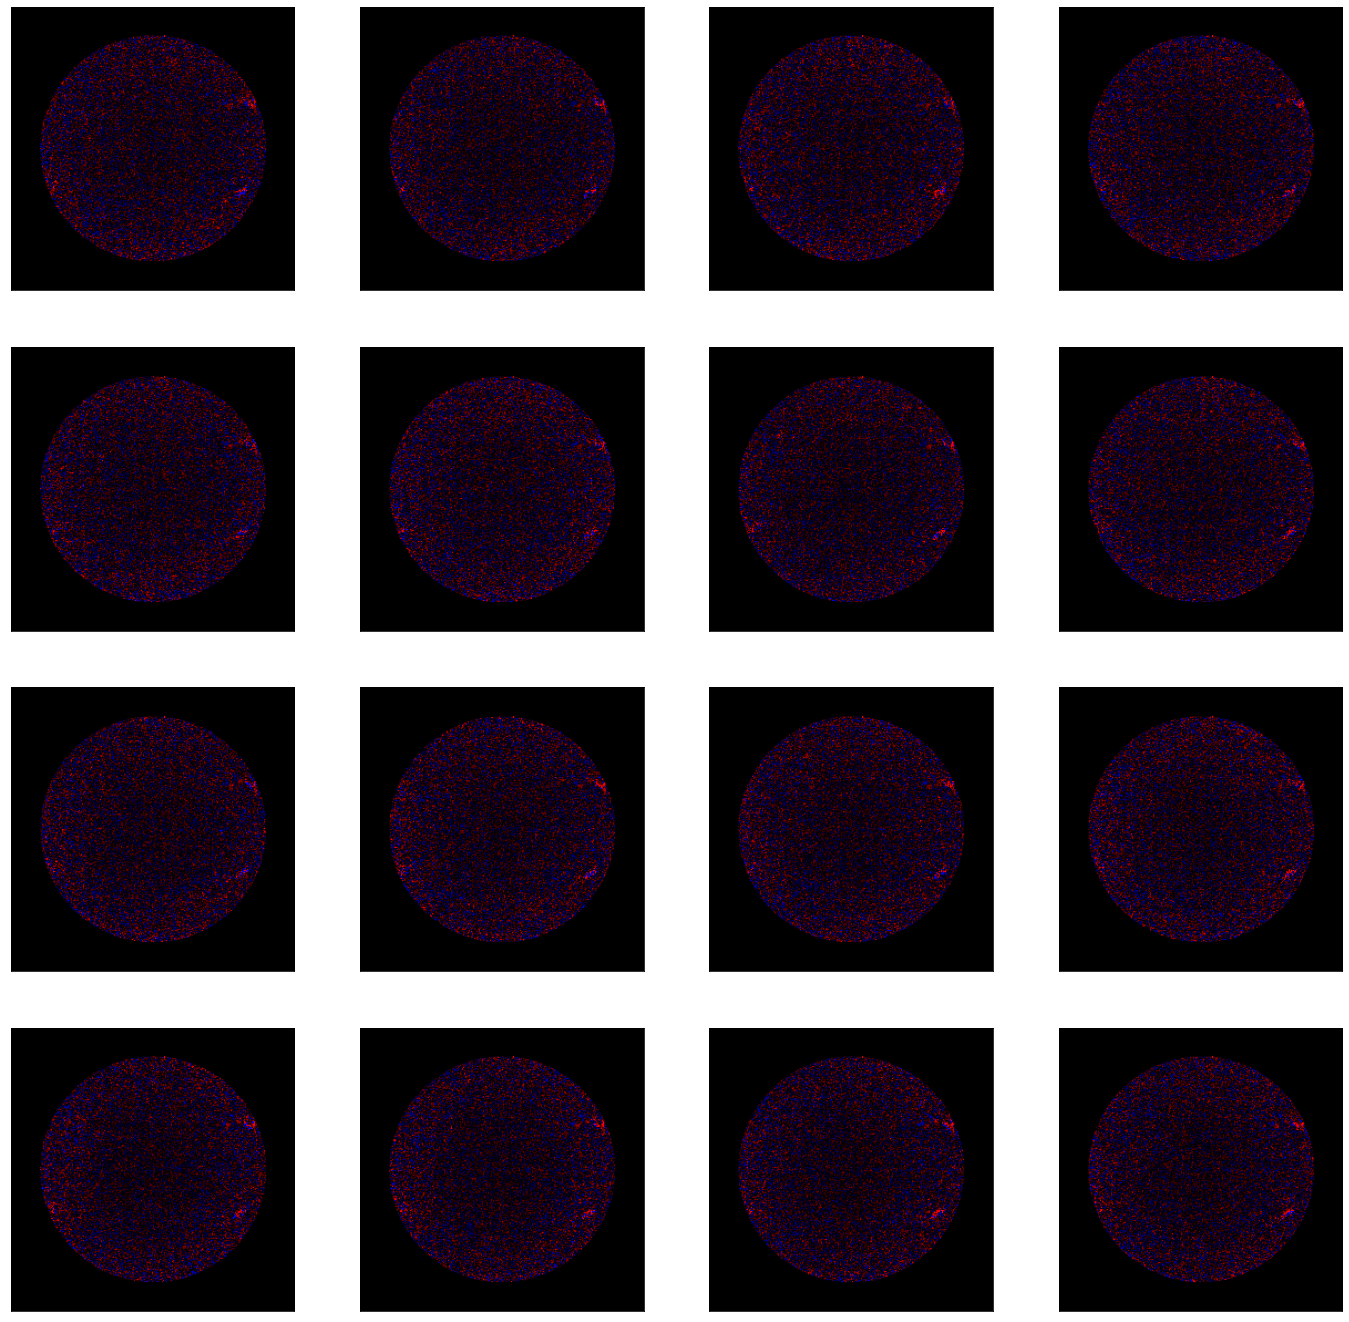

In [11]:
for batch_idx, samples in enumerate(loader):
    X, y = samples
    V = []
    for x in X:
        x = x.permute(1,2,0) # torch to pillow
        x = np.squeeze(x.numpy())
        v = vis(x, channel_to_map("Bx"), get_clip(x, "Bx"))
        V.append(Image.fromarray(v))
    show_grid(V)
    break